In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Set seeds for reproducibility
torch.manual_seed(500)
np.random.seed(500)

# Define the neural network with the hard boundary condition built-in
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )
        
    def forward(self, x):
        return x * (1 - x) * self.net(x)

# Define f(x) = -6x +3 (so that the exact solution is u(x) = x(x-1)(x-0.5))
def f(x):
    return -6 * x + 3

# Define the Deep Ritz loss 
def deep_ritz_loss(model, x_grad, x_pot):
    # Gradient term:
    x_grad.requires_grad_(True)
    
    u_grad = model(x_grad)
    u_x = torch.autograd.grad(u_grad, x_grad, grad_outputs=torch.ones_like(u_grad), create_graph=True)[0]
    loss_grad=torch.mean(0.5*u_x**2)
    
    # Potential term:
    u_pot=model(x_pot)
    loss_pot = torch.mean(-f(x_pot)*u_pot)
    
    return loss_grad + loss_pot

# Training
model = FCNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 10000
loss_history = []

for epoch in range(epochs):
    
    x_grad = torch.rand(5000, 1)
    x_pot = torch.rand(1000,1)
    
    optimizer.zero_grad()
    loss = deep_ritz_loss(model, x_grad, x_pot)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

# Plotting the result
x_test = torch.linspace(0, 1, 200).reshape(-1, 1)
with torch.no_grad():
    u_pred = model(x_test).numpy()

# Exact solution: u(x) = x(x - 1)(x - 0.5)
u_exact = (x_test.numpy() * ( x_test.numpy()-1) * (x_test.numpy() - 0.5))



Epoch 0, Loss: -0.00361
Epoch 500, Loss: -0.02635
Epoch 1000, Loss: -0.02554
Epoch 1500, Loss: -0.02413
Epoch 2000, Loss: -0.02357
Epoch 2500, Loss: -0.02302
Epoch 3000, Loss: -0.02327
Epoch 3500, Loss: -0.02453
Epoch 4000, Loss: -0.02512
Epoch 4500, Loss: -0.02319
Epoch 5000, Loss: -0.02514
Epoch 5500, Loss: -0.02403
Epoch 6000, Loss: -0.02575
Epoch 6500, Loss: -0.02385
Epoch 7000, Loss: -0.02438
Epoch 7500, Loss: -0.02175
Epoch 8000, Loss: -0.02503
Epoch 8500, Loss: -0.02541
Epoch 9000, Loss: -0.02401
Epoch 9500, Loss: -0.02413


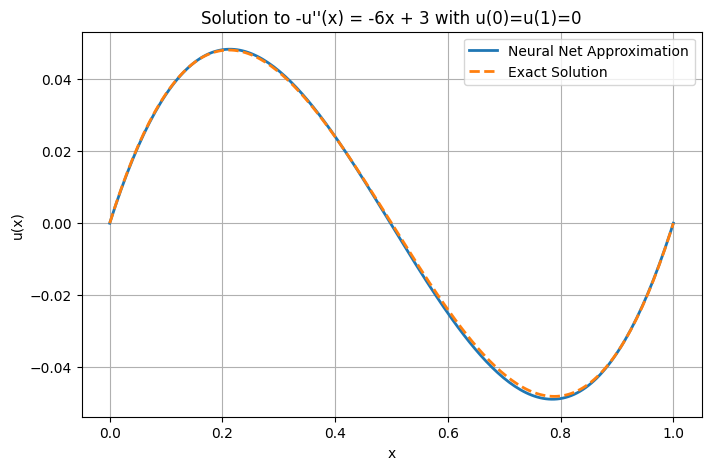

In [2]:
plt.figure(figsize=(8,5))
plt.plot(x_test, u_pred, label='Neural Net Approximation', linewidth=2)
plt.plot(x_test, u_exact, '--', label='Exact Solution', linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Solution to -u''(x) = -6x + 3 with u(0)=u(1)=0")
plt.legend()
plt.grid(True)
plt.savefig("cubic_deepritz_plot.pdf")
plt.show()

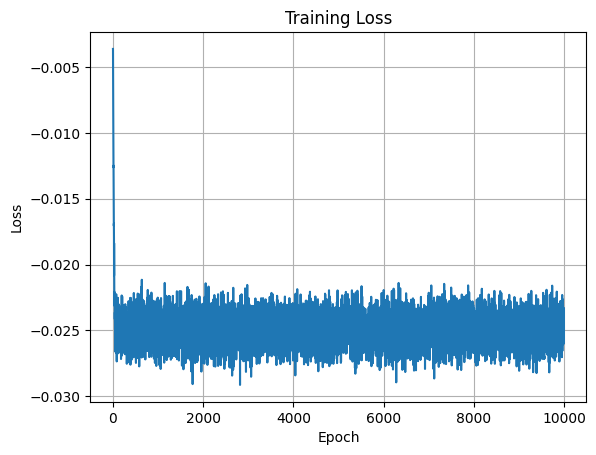

In [3]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.savefig("cubic_deepritz_loss.pdf")
plt.show()

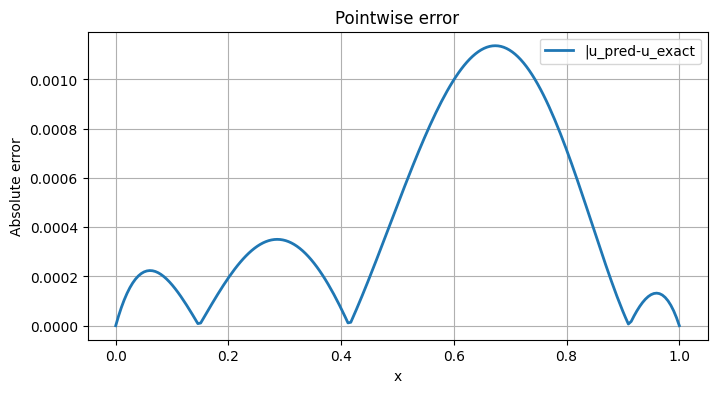

In [4]:
error=np.abs(u_pred-u_exact)
plt.figure(figsize=(8,4))
plt.plot(x_test, error, label='|u_pred-u_exact', linewidth=2)

plt.xlabel("x")
plt.ylabel("Absolute error")
plt.title("Pointwise error")
plt.legend()
plt.grid(True)
plt.savefig("cubic_deepritz_error.pdf")
plt.show()